In [ ]:
%autosave 0
import sys
!{sys.executable} -m pip install ..

In [1]:
from tope import Tope
from tope.net import *
from tope.orth import *
from tope.graph import Graph
from tope.plot import plot_artists_in_view

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import json, os

# import prepackaged data
with open("../data/polys2.json") as fd: 
    polys = json.load(fd)
    
logger.remove()

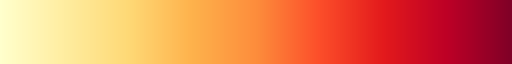

In [2]:
mpl.colormaps.get("YlOrRd")

In [3]:
def create_lc(edges, color_map = "Set2"):
    segments = []
    colors = []
    cmap = mpl.colormaps.get(color_map)
    for i, edge in enumerate(edges):
        segments.append(edge)
        colors.append(cmap(0.25+ 0.5*i/len(edges)))
    return mpl.collections.LineCollection(segments, color=colors)

# Parameters

In [4]:
POLYTOPE     = "24-cell"
FIG_FILENAME = "nets-unfolded.png"
STL_FILENAME = "thing24.stl"
COLOR_MAP    = "YlOrRd"

## Randomization

In [5]:
Q = random_orth(3)

# Actually do the stuff

In [6]:
P = Tope.from_vertices(polys[POLYTOPE])
T = P.facet_graph().width_first_spanning_tree()
N = Net(P, T).unfold().in_own_span()

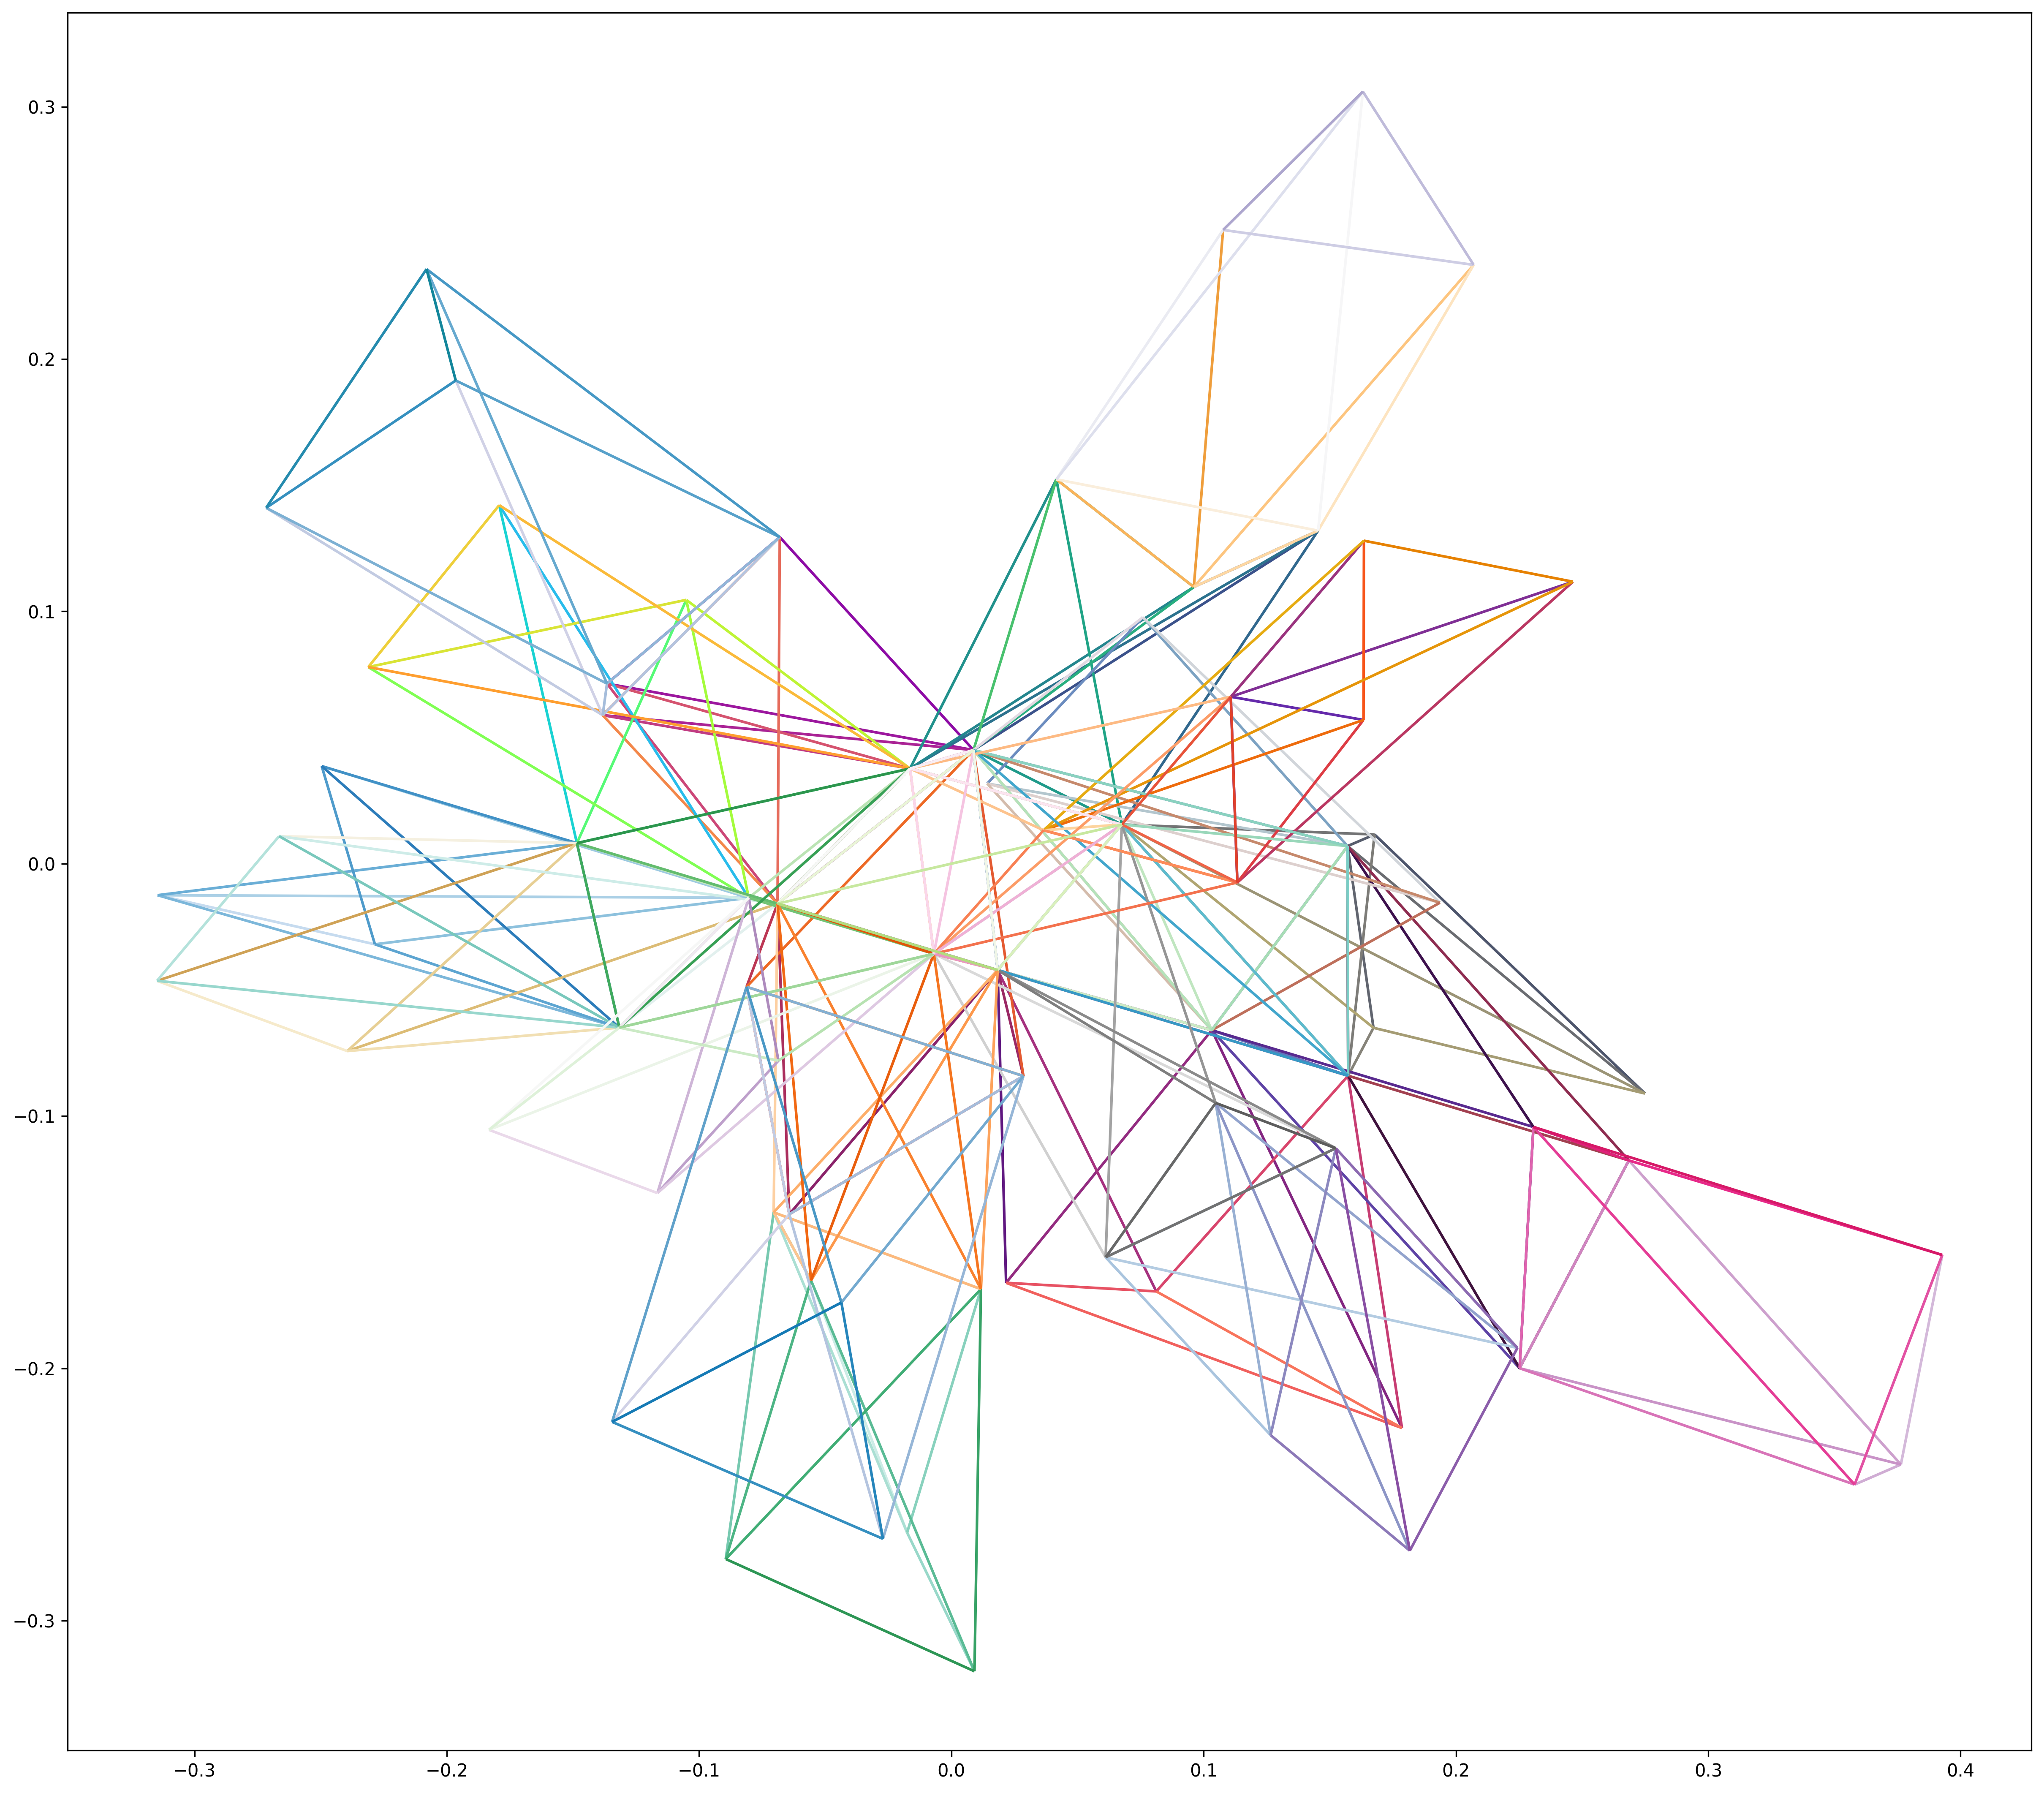

In [7]:
fig, ax = plt.subplots(dpi=300)

cell_edges = [np.stack([F.vertices[sorted(e)] for e in F.iter_faces(1)]) for F in N.facets.values()]
cmaps = list(mpl.colormaps)

for n, cell in enumerate(cell_edges):
    edges = perspective_project(cell @ Q, 10)
    lc = create_lc(edges, color_map = cmaps[n%len(cmaps)])
    ax.add_collection(lc)
#    for ax in axs[:n+1]:
#        lc = create_lc(edges, color_map = cmaps[n%len(cmaps)])
#        ax.add_collection(lc)
        
#bbox = axs[0].dataLim
        
#for ax in axs:
#    ax.dataLim = bbox
ax.set_aspect("equal")
ax.autoscale()

fig.set_size_inches(20,20)
fig.savefig("nets-builder1.png")

# Make STL

In [ ]:
from stl import mesh

def create_stl(N: Net) -> mesh.Mesh:
    triangles = [face for face in facet.iter_faces_as_vertices(2) for facet in N.facets.values()]
    model = mesh.Mesh(np.zeros(len(triangles), dtype=stl.mesh.Mesh.dtype))
    model.vectors[:,:,:] = faces
    return model

In [ ]:
thing = create_stl(N)
thing.save(STL_FILENAME)